# **Анализ временных рядов с помощью Python. Метод экспоненциального сглаживания (модель ETS)**

### Авторы: Нефедова Мария, Павлеева Мария

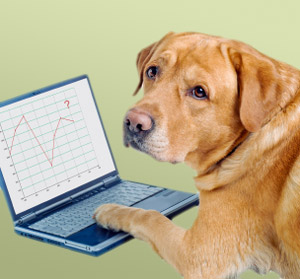

##Цель

В данном туториале мы познакомимся с одним из методов прогнозирования временных рядов: методом экспоненциального сглаживания (ETS). Кроме того, мы разберемся в том, как подобрать наиболее подходящую модель двумя разными способами (аналитически и автоматически) и попробуем применить метод скользящего окна для оценки качества моделей. 

## **Cодержание**


- Теория 
    - Модель ETS
    - Модификации модели ETS
- Практика 
    - Установка библиотеки
    - Данные
    - Обучение модели
    - Прогнозирование
    - Автоматический подбор модели
    - Сравнение моделей с помощью скользящего окна
- Итог
- Полезные ссылки







## **Теория**

Наряду с уже известными моделями прогнозирования, такими как ARMA, ARIMA, GARCH, существует еще не такой известный в русской литературе класс моделей ETS, в основе которых лежит экспоненциальное сглаживание. 

Экспоненциальное сглаживание - метод прогнозирования, при котором значения переменной за все предыдущие периоды входят в прогноз, экспоненциально теряя свой вес со временем. Это позволяет модели с достаточной степенью гибко реагировать на новейшие изменения в данных, сохраняя при этом информацию об историческом поведении временного ряда.

В простейшей форме экспоненциальное сглаживание выглядит как

$$Прогноз: \hat y_{t+h|t} = l_t$$

$$Сглаживание: l_t = \alpha y_t + (1-\alpha)l_{t-1},$$

где $y_t$ – значение переменной $y$ в момент времени $t$, $\hat y_{t+h|t}$ – прогноз на период $t + h$ по значениям $y$ до $t$, $\alpha$ – настраиваемый параметр.

Раскрыв скобки в выражении для сглаживания, мы получим следущее:

$$l_t = \alpha y_t + (1-\alpha)l_{t-1} = l_{t-1} + \alpha(y_t - l_{t-1}) = l_{t-1} + \alpha \epsilon_t,$$ где $\epsilon_t = y_t - l_{t-1} = y_t - \hat y_{t+h|t}$ - ошибка прогноза (т.е. разница между истинным и спрогнозированным значением) в момент времени $t$.
 

# Модель ETS


Модель ETS состоит из трех компонентов:
- **e**rror $(\epsilon_t)$ - ошибка
- **t**rend $(b_t)$ - тренд
- **s**easonality $(s_t)$ - сезонность

Каждый компонент может быть аддитивными (A) или мультипликативными (M), а также отсутствовать в модели (N) [кроме ошибки], что обычно отражается в названии модели. Например, ETS(A,N,N) содержит аддитивные ошибки и не содержит ни тренда, ни сезонного фактора.

**Аддитивная модель** является линейной и предполагает, что компоненты складываются

 $y_t = Error + Trend + Seasonality$ , то есть тренд выражен прямой линией, а сезонность имеет одинаковую частоту (ширина циклов) и амплитуду (высота циклов).

**Мультипликативная модель**  является нелинейной и предполагает, что компоненты перемножаются

 $y_t = Error \cdot Trend \cdot Seasonality$, то есть тренд выражен изогнутой линией, а сезонность имеет возрастающую или уменьшающуюся частоту и/или амплитуду во времени.


Перед определением типа каждого компонента обычно смотрят на графическое представление временного ряда, определяя линейность/нелинейность тренда и сезонности.

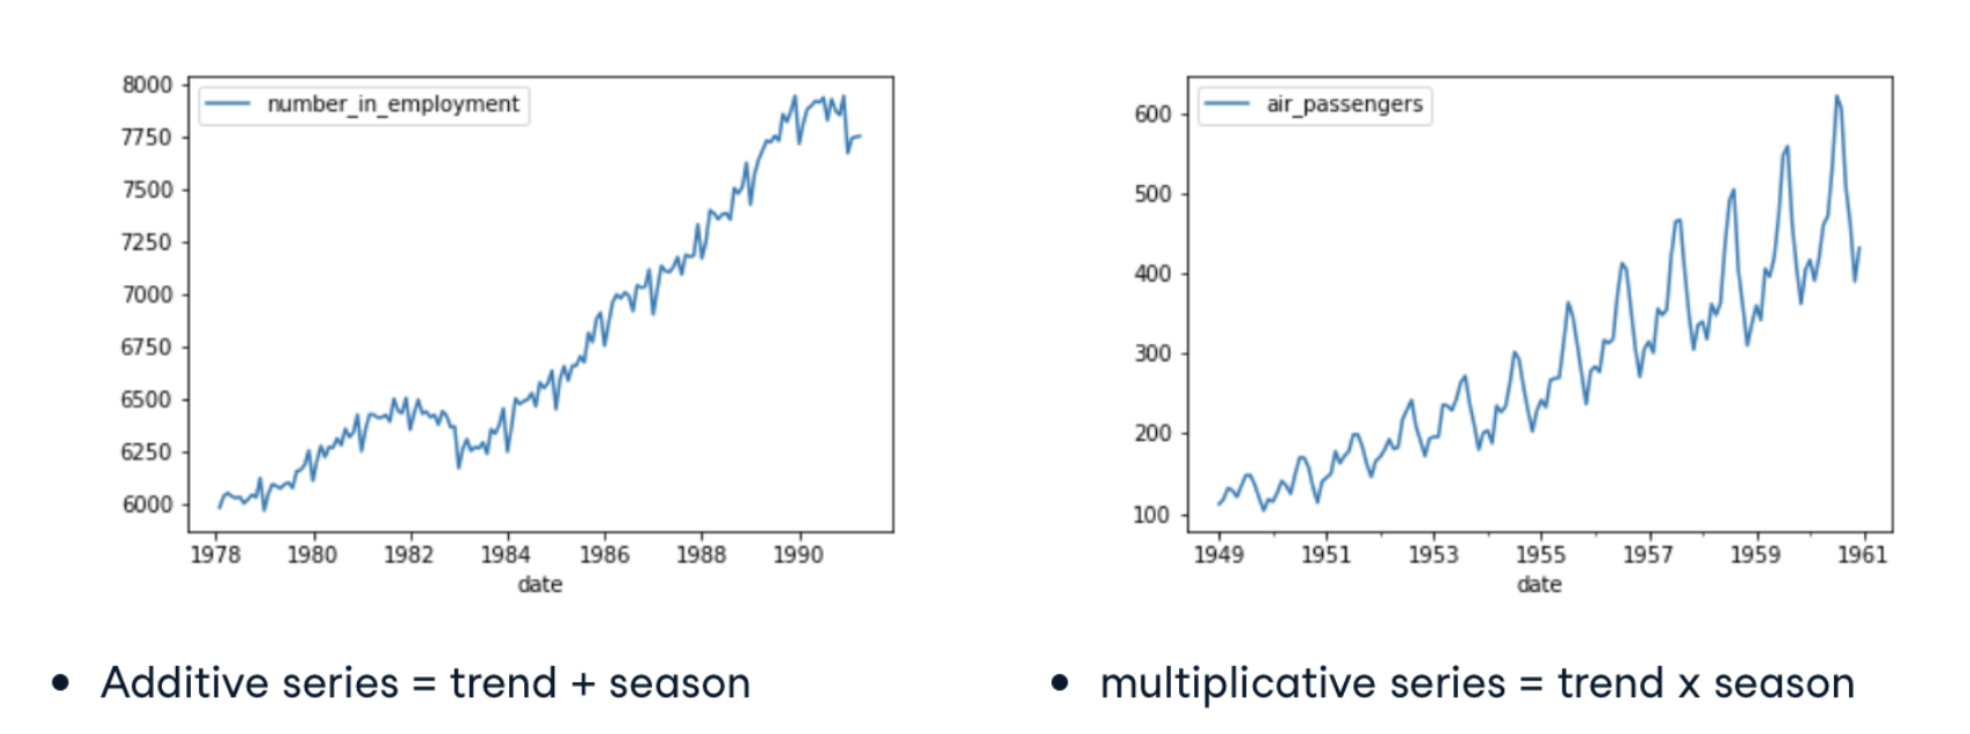

Этот метод не дает информации о типе ошибки, однако в его определении может помочь в определении изображение разложенного временного ряда (посмотрим на него в практической части).

## Модификации модели ETS

Для того, что иметь более подробное представление о том, как различаются модели, можно посмотреть на их уравнения.

Ниже представлены уравнения, взятые из онлайн-учебника [Forecasting: Principles and Practice](https://otexts.com/fpp3/ets.html) Роба Хиндмана и Джорджа Атанасопулоса, сначала для моделей с аддитивными ошибками (и всеми комбинациями тренда и сезонности), затем уравнения для моделей с мультипликативными ошибками.




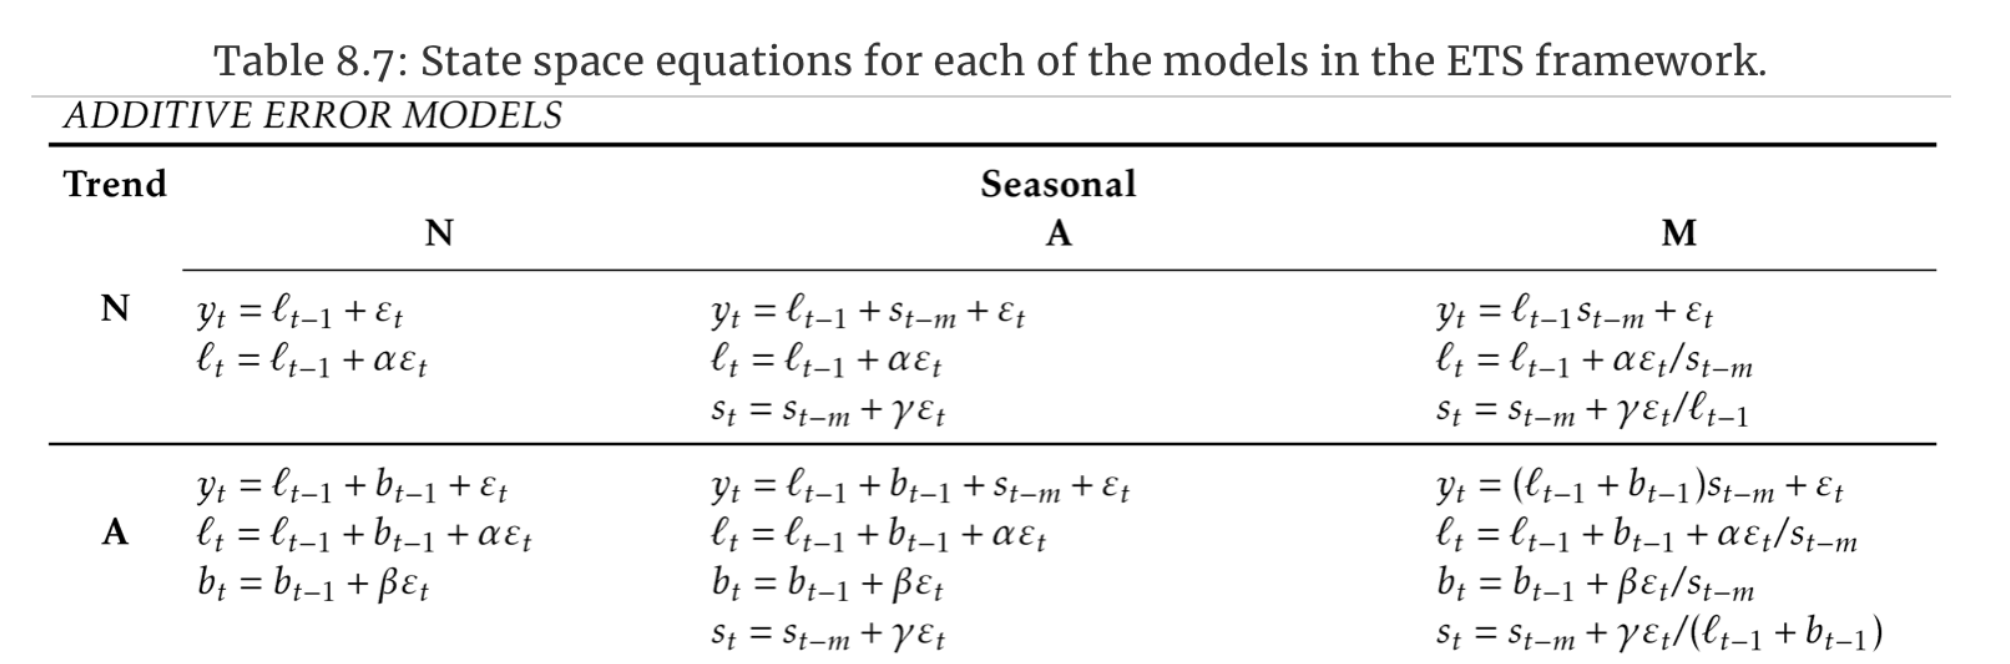

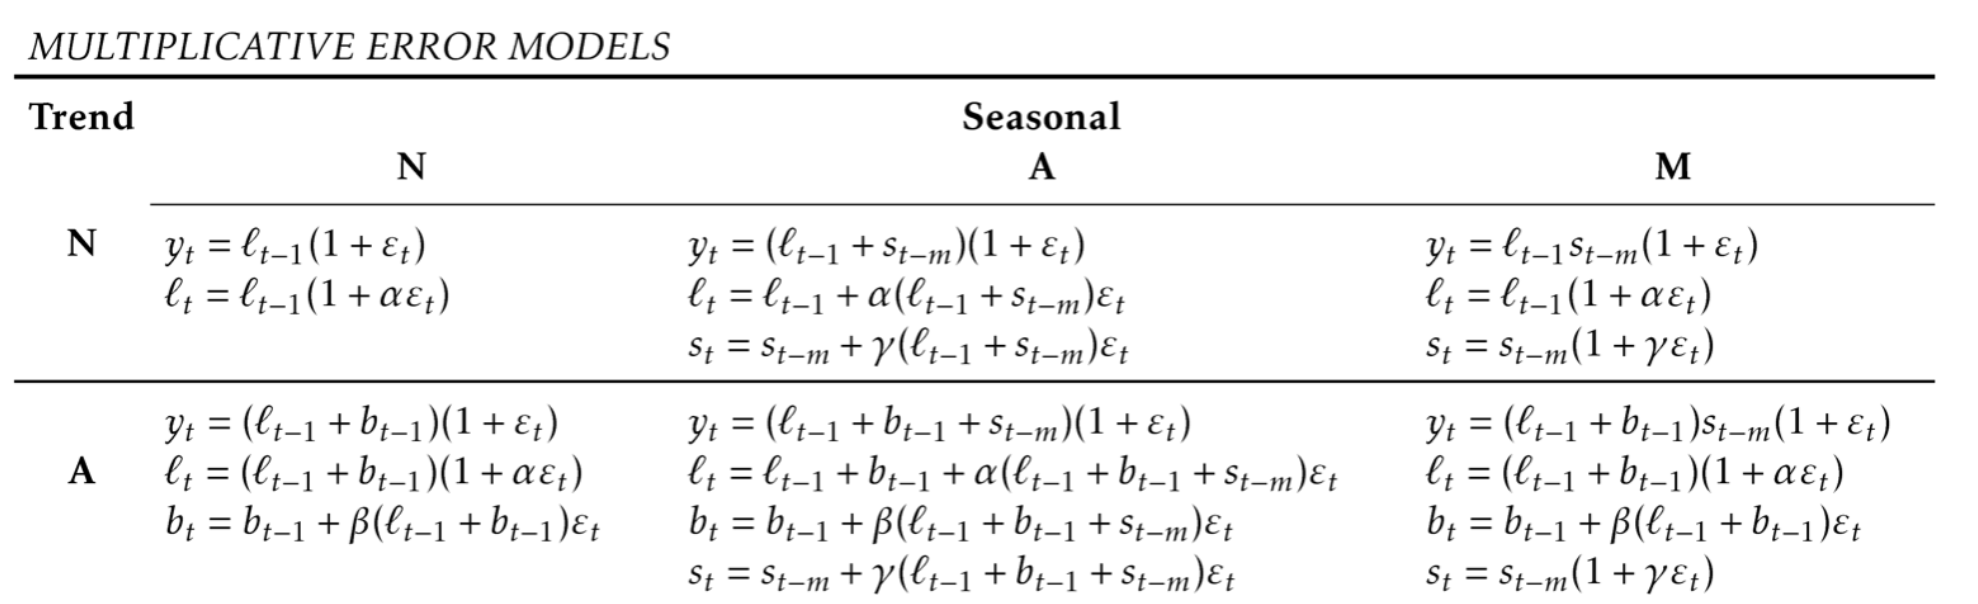

## **Практика**

Для проведения анализа и прогнозирования будем использовать модуль [sktime](https://www.sktime.org/en/latest/), который предоставляет широкий набор средств и методов для прогнозирования и классификации временных рядов с помощью различных моделей. 


## Данные



Для анализа и прогнозирования мы будем использовать данные взятые с платформы DataCamp, отражающие ежемесячное производство молока в фунтах. 


Для начала подключим необходимые модули и их атрибуты:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sktime.utils.plotting import plot_series

from sktime.forecasting.model_selection import temporal_train_test_split 
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon 

from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV 
from sktime.performance_metrics.forecasting import sMAPE, smape_loss 
from sklearn.metrics import mean_squared_error

Далее загрузим данные и посмотрим на них:

In [3]:
y = pd.read_csv("https://assets.datacamp.com/production/repositories/4567/datasets/1213fc15035051ef7fe5a0dac44176df7223a93a/milk_production.csv")
y.head()

,date,pounds_per_cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


Для того, чтобы работать с данными в sktime, их необходимо привести к определенному формату: index $\rightarrow$ PeriodIndex 

In [4]:
y['date'] = pd.to_datetime(y['date'])
y = pd.Series(y['pounds_per_cow'].values, index=y['date']) 
y.index = y.index.to_period('M')
y

date
1962-01    589.0
1962-02    561.0
1962-03    640.0
1962-04    656.0
1962-05    727.0
           ...  
1975-08    858.0
1975-09    817.0
1975-10    827.0
1975-11    797.0
1975-12    843.0
Freq: M, Length: 168, dtype: float64

In [5]:
y.index

PeriodIndex(['1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10',
             ...
             '1975-03', '1975-04', '1975-05', '1975-06', '1975-07', '1975-08',
             '1975-09', '1975-10', '1975-11', '1975-12'],
            dtype='period[M]', name='date', length=168, freq='M')

Более подробно о том, как работать с различными структурами данных в sktime, можно посмотреть [здесь](https://www.sktime.org/en/latest/examples/loading_data.html).

Прежде чем проводить содержательный прогноз временного ряда, необходимо определить, из каких компонент он состоит. Самый простой способ — провести предварительный анализ, взглянув на его графическое изображение.

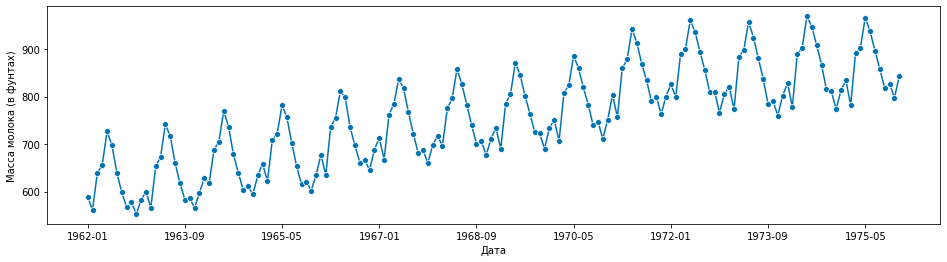

In [6]:
plot_series(y)
plt.xlabel("Дата")
plt.ylabel("Масса молока (в фунтах)")

plt.show()

По графику заметно, что в данных наблюдается как тренд, так и месячная сезонность, при этом с кажется, что модель скорее аддитивная, так как тренд имеет практически линейный вид, а амплитуда сезонности не меняется со временем. 


Подтвердить эти гипотезы может изображения разложенного временного ряда.

К сожалению, в sktime пока не реализована такая функция, поэтому будем использовать библиотеку statsmodels для этих целей. Для этого необходимо преобразовать формат даты таким образом:

<Figure size 432x288 with 0 Axes>

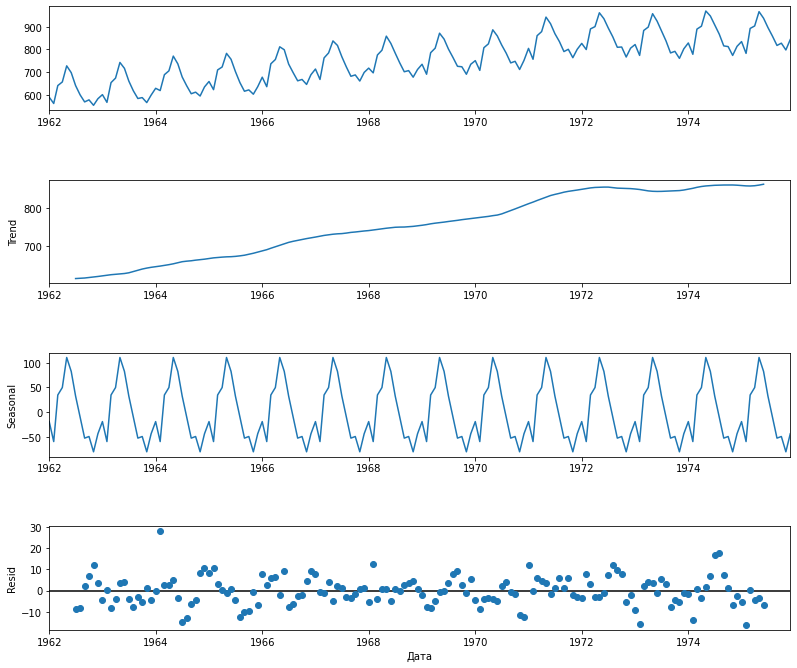

In [7]:
df = y.copy()
df.index = df.index.to_timestamp()
decompose = seasonal_decompose(df)

fig = plt.figure()  
fig = decompose.plot()  
plt.xlabel("Дата")
fig.set_size_inches(12, 10)

plt.show()

Графики тренда и сезонного фактора в целом доказывают нашу гипотезу, хотя тренд не 100% линеен. Так же можно заметить, что разброс ошибок в целом не меняется со временем.

Исходя из полученной информации можно предположить, что наиболее подходящая модель для данного временного ряда - это ETS(A, A, A), которая формульно записывается как: 

$$y_t = l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_t$$
$$l_t = l_{t-1} + b_{t-1} + \alpha\epsilon_t$$
$$b_t = b_{t-1} + \beta\epsilon_t$$
$$s_t = s_{t-m} + \gamma\epsilon_t$$

## Обучение модели

Для начала разобьем наш ряд на обучающую и тестовую выборки, взяв для тестирования последние 3 года.

(Так как каждая точка временного ряда представляет собой месяц, нужно указывать месяц * количество лет, т.е. 12 * 3 = 36).

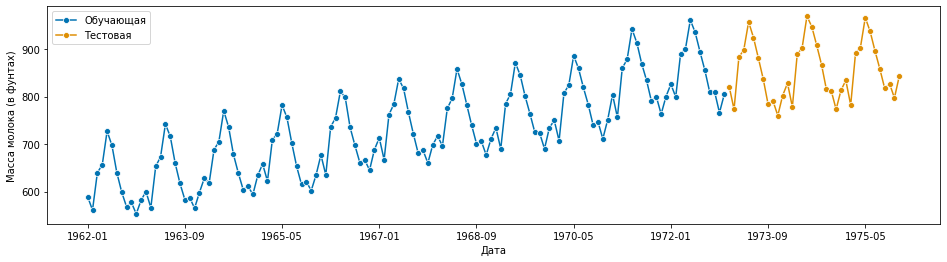

In [8]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=['Обучающая', 'Тестовая'])
plt.xlabel("Дата")
plt.ylabel("Масса молока (в фунтах)")

plt.show()

Ранее мы уже предположили вид модели, а именно ETS(A, A, A). Давайте обучим ее и сравним с тривиальной сезонной моделью ETS(A, N, A).

In [9]:
ets_ana = AutoETS(error='add', trend=None, seasonal='add', sp=12).fit(y_train)
ets_aaa = AutoETS(error='add', trend='add', seasonal='add', sp=12).fit(y_train)

In [10]:
ets_aaa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:                       ETS(AAA)   Log Likelihood                -439.018
Date:                Wed, 03 Mar 2021   AIC                            914.036
Time:                        16:53:47   BIC                            965.926
Sample:                    01-31-1962   HQIC                           935.122
                         - 12-31-1972   Scale                           45.327
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6830      0.077      8.925      0.000       0.533       0.833
smoothing_trend       6.83e-05        nan        nan        nan         nan         nan
smoothing_seasonal    3.17e-05        nan        nan        nan         nan         nan
initial_level         588.1179        nan        nan        nan         nan         nan
initial_trend           1.8476      0.406      4.550      0.000       1.052       2.643
initial_seasonal.0    -25.7706        nan        nan        nan         nan         nan
initial_seasonal.1    -61.1977        nan        nan        nan         nan         nan
initial_seasonal.2    -31.1680        nan        nan        nan         nan         nan
initial_seasonal.3    -34.6887        nan        nan        nan         nan         nan
initial_seasonal.4      5.8872        nan        nan        nan         nan         nan
initial_seasonal.5     48.1928        nan        nan        nan         nan         nan
initial_seasonal.6    100.0376        nan        nan        nan         nan         nan
initial_seasonal.7    128.1576        nan        nan        nan         nan         nan
initial_seasonal.8     67.3701        nan        nan        nan         nan         nan
initial_seasonal.9     51.6747        nan        nan        nan         nan         nan
initial_seasonal.10   -36.2960        nan        nan        nan         nan         nan
initial_seasonal.11          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       18.73   Jarque-Bera (JB):                25.05
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.63
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Напомним, что в общем виде модель ETS(A, A, A) имеет вид:

$$y_t = l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_t$$
$$l_t = l_{t-1} + b_{t-1} + \alpha\epsilon_t$$
$$b_t = b_{t-1} + \beta\epsilon_t$$
$$s_t = s_{t-m} + \gamma\epsilon_t$$



Для создания прогноза нам необходимо было оценить сглаживающие параметры модели: $\alpha, \beta, \gamma$, а также начальные состояния: $l_0, b_0, s_{-0}, \dots, s_{-m+1}.$ В нашем случае, сезонность месячная (m=12), поэтому оцениваются значения $s_{-0}, \dots, s_{-11}$.

Так, подставляя полученные на обучающей выборке коэффициенты, мы имеем:

$$y_t = l_{t-1} + b_{t-1} + s_{t-12} + \epsilon_t$$
$$l_t = l_{t-1} + b_{t-1} + 0.683\epsilon_t$$
$$b_t = b_{t-1} + 0.0000683\epsilon_t$$
$$s_t = s_{t-12} + 0.0000317\epsilon_t,$$

где $l_0 = 588.1179, b_0 = 1.8476, s_{-0} = -25.77, s_{-1} = -61.19, \dots , s_{-11} = 0.$

Посмотрим теперь на тривиальную модель ETS(A, N, A):

In [11]:
ets_ana.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:                       ETS(ANA)   Log Likelihood                -446.949
Date:                Wed, 03 Mar 2021   AIC                            925.898
Time:                        16:53:47   BIC                            972.023
Sample:                    01-31-1962   HQIC                           944.641
                         - 12-31-1972   Scale                           51.115
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.8230      0.074     11.056      0.000       0.677       0.969
smoothing_seasonal    1.77e-05        nan        nan        nan         nan         nan
initial_level         590.1814   3.22e+04      0.018      0.985   -6.25e+04    6.37e+04
initial_seasonal.0    -25.4648   3.22e+04     -0.001      0.999   -6.31e+04    6.31e+04
initial_seasonal.1    -60.9181   3.22e+04     -0.002      0.998   -6.31e+04     6.3e+04
initial_seasonal.2    -30.9168   3.22e+04     -0.001      0.999   -6.31e+04     6.3e+04
initial_seasonal.3    -34.4545   3.22e+04     -0.001      0.999   -6.31e+04     6.3e+04
initial_seasonal.4      6.0937   3.22e+04      0.000      1.000   -6.31e+04    6.31e+04
initial_seasonal.5     48.3702   3.22e+04      0.002      0.999    -6.3e+04    6.31e+04
initial_seasonal.6    100.1892   3.22e+04      0.003      0.998    -6.3e+04    6.32e+04
initial_seasonal.7    128.2794   3.22e+04      0.004      0.997   -6.29e+04    6.32e+04
initial_seasonal.8     67.4578   3.22e+04      0.002      0.998    -6.3e+04    6.31e+04
initial_seasonal.9     51.7299   3.22e+04      0.002      0.999    -6.3e+04    6.31e+04
initial_seasonal.10   -36.2717   3.22e+04     -0.001      0.999   -6.31e+04     6.3e+04
initial_seasonal.11          0   3.22e+04          0      1.000   -6.31e+04    6.31e+04
===================================================================================
Ljung-Box (Q):                       20.38   Jarque-Bera (JB):                24.54
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.62
Prob(H) (two-sided):                  0.67   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Формульно модель ETS(A, N, A) записывается как:

$$y_t = l_{t-1} + s_{t-m} + \epsilon_t$$
$$l_t = l_{t-1} + \alpha\epsilon_t$$
$$s_t = s_{t-m} + \gamma\epsilon_t,$$

то есть в ней просто отсутствует трендовая состовляющая. Однако коэффициенты получились другими:

$$y_t = l_{t-1} + s_{t-12} + \epsilon_t$$
$$l_t = l_{t-1} + 0.823\epsilon_t$$
$$s_t = s_{t-12} + 0.0000177\epsilon_t$$ c $l_0=590.1814, s_{-0} = -25.4648, \dots, s_{-11} = 0.$

## Прогнозирование

Построим прогноз на тестовой выборке, используя полученную модель. В sktime для этого необходимо вначале задать горизонт прогнозирования, используя абсолютные временные точки, которые мы хотим предсказать (например, с помощью класса ForecastingHorizon).

In [12]:
horizon = ForecastingHorizon(y_test.index, is_relative=False)
horizon

ForecastingHorizon(['1973-01', '1973-02', '1973-03', '1973-04', '1973-05', '1973-06',
             '1973-07', '1973-08', '1973-09', '1973-10', '1973-11', '1973-12',
             '1974-01', '1974-02', '1974-03', '1974-04', '1974-05', '1974-06',
             '1974-07', '1974-08', '1974-09', '1974-10', '1974-11', '1974-12',
             '1975-01', '1975-02', '1975-03', '1975-04', '1975-05', '1975-06',
             '1975-07', '1975-08', '1975-09', '1975-10', '1975-11', '1975-12'],
            dtype='period[M]', name='date', freq='M', is_relative=False)

In [13]:
y_pred_aaa = ets_aaa.predict(horizon)
y_pred_aaa.head()

date
1973-01    833.860244
1973-02    799.411824
1973-03    889.230178
1973-04    906.773208
1973-05    969.408265
Freq: M, dtype: float64

In [14]:
y_pred_ana = ets_ana.predict(horizon)
y_pred_ana.head()

date
1973-01    830.294098
1973-02    794.022391
1973-03    882.024009
1973-04    897.751942
1973-05    958.573453
Freq: M, dtype: float64

Посмотрим на диаграмму прогноза для тестовой выборки, чтобы наглядно сравнить качество моделей: 

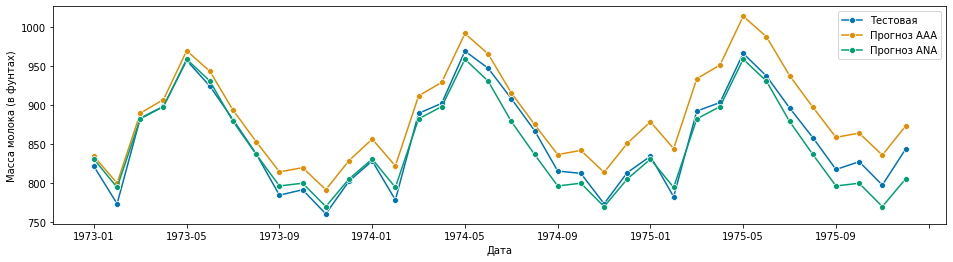

In [15]:
plot_series(y_test, y_pred_aaa, y_pred_ana, labels=['Тестовая','Прогноз AAA', 'Прогноз ANA'])
plt.xlabel("Дата")
plt.ylabel("Масса молока (в фунтах)")

plt.show()

Видно, что оба прогноза близки к настоящим значениям, однако кажется, что модель без тренда лучше предсказывает истинные значения.


## Автоматический подбор модели

Помимо других удобных методов, в sktime есть возможность автоматического подбора модели ETS. Давайте им воспользуемся.

In [16]:
ets_auto = AutoETS(auto=True, sp=12).fit(y_train)
ets_auto.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1135: RuntimeWarning: invalid value encountered in log
  logL -= np.sum(np.log(yhat))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:                       ETS(AAA)   Log Likelihood                -439.018
Date:                Wed, 03 Mar 2021   AIC                            914.036
Time:                        16:53:51   BIC                            965.926
Sample:                    01-31-1962   HQIC                           935.122
                         - 12-31-1972   Scale                           45.327
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6830      0.077      8.925      0.000       0.533       0.833
smoothing_trend       6.83e-05        nan        nan        nan         nan         nan
smoothing_seasonal    3.17e-05        nan        nan        nan         nan         nan
initial_level         588.1179        nan        nan        nan         nan         nan
initial_trend           1.8476      0.406      4.550      0.000       1.052       2.643
initial_seasonal.0    -25.7706        nan        nan        nan         nan         nan
initial_seasonal.1    -61.1977        nan        nan        nan         nan         nan
initial_seasonal.2    -31.1680        nan        nan        nan         nan         nan
initial_seasonal.3    -34.6887        nan        nan        nan         nan         nan
initial_seasonal.4      5.8872        nan        nan        nan         nan         nan
initial_seasonal.5     48.1928        nan        nan        nan         nan         nan
initial_seasonal.6    100.0376        nan        nan        nan         nan         nan
initial_seasonal.7    128.1576        nan        nan        nan         nan         nan
initial_seasonal.8     67.3701        nan        nan        nan         nan         nan
initial_seasonal.9     51.6747        nan        nan        nan         nan         nan
initial_seasonal.10   -36.2960        nan        nan        nan         nan         nan
initial_seasonal.11          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       18.73   Jarque-Bera (JB):                25.05
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.63
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Автоподбор указал на модель ETS(A, A, A), которую мы ранее выбрали в связи с предположением об аддитивности всех компонент. 

Тем не менее, на диаграмме выше было обнаружено, что модель без тренда лучше справляется с задачей прогнозирования на нашей тестовой выборке. Почему же автоподбор не выбрал ее?

Дело в том, что функция автоподбора выбирает модели по информационному критерию Акаике ([AIC](https://wiki.loginom.ru/articles/aic.html)), который позволяет найти компромисс между сложностью модели (числом параметров) и ее точностью по ***тренировочной*** выборке.

Именно поэтому автоматически подобранная модель не всегда наилучшая в прогнозировании данных на тестовой выборке:

In [17]:
print("Модель\t    Среднеквадратичная ошибка")
print("ETS(AAA)\t", mean_squared_error(y_test, y_pred_aaa))
print("ETS(ANA)\t", mean_squared_error(y_test, y_pred_ana))
print("----------------------------")
print("MSE ETS(AAA) >> MSE ETS(ANA)")

Модель	    Среднеквадратичная ошибка
ETS(AAA)	 1049.54330459028
ETS(ANA)	 238.3781160269076
----------------------------
MSE ETS(AAA) >> MSE ETS(ANA)


## Сравнение моделей с помощью метода скользящего окна

### Метод скользящего окна

Метод скользящего окна -  алгоритм, позволяющий сформировать из членов временного ряда набор данных, который может служить обучающим множеством для построения модели прогнозирования. 

В основе этого метода лежит идея повторения разделения данных на обучающую и тестовую выборки (со сдвигом во времени) и последующем усреднении качества каждого прогноза. То есть выделяется некоторый непрерывный отрезок данных, называемый окном, а окно, в свою очередь, перемещается – «скользит» – по всему исходному набору данных. 

Чаще всего он используется для построения кратковременных прогнозов c целью уменьшения дисперсии ошибки, которая возникает из-за маленького размера тестовой выборки. 



Для того, чтобы лучше понять, как работает метод скользящего окна, рассмотрим его на примере.

###Поясняющий пример

Возьмем временной ряд и определим в обучающую выборку его первые 80 наблюдений, а в тестовую 81-е наблюдение. Так как окно - это временной интервал обучающий выборки, то в нашем случае размер окна будет равен 80. 

Далее построим прогноз и сделаем сдвиг начала и конца обоих выборок на 1 наблюдение, то есть теперь обучающая выборка содержит наблюдения с 2 по 81, а тестовая 82-е наблюдение.

Продолжим алгоритм пока не закончатся данные, а затем посчитаем среднюю ошибку. Так мы получим более точное представление о качестве модели, нежели при одинарном разбиении данных и оценке одного прогноза.

(Чаще всего делается сдвиг на 1 наблюдение, однако иногда берут сдвиг на несколько наблюдений для многоступенчатого прогноза. Тогда размер окна (обучающей выборки) называют глубиной прогноза, а тестовые значения горизонтом прогноза)


Визуально, метод скользящего окна выглядит так:

In [18]:
from IPython.display import Image
Image(url='https://wideops.com/wp-content/uploads/1_sliding_window_on_an_example_dataset-1.gif')

Скользящее окно на примере набора данных. Каждое окно, *feature window*, представляет собой вектор для набора данных (обучающую выборку), а *label(s)* - это одна или несколько точек в будущем (тестовая выборка).

### Применение на данных

Так как мы уже находили наиболее точную модель для данных по производству молока, давайте возьмем другой временной ряд. В этот раз это будут данные по ежемесячному производству конфет в США в период с 1972 по 2018 год.

Повторим шаги из предыдущего раздела: посмотрим на сам ряд и построим его отдельные компоненты. 

In [19]:
y = pd.read_csv("https://assets.datacamp.com/production/repositories/4567/datasets/0707fe926ef5f110ed889fcd2a09c9417e2ffbb6/candy_production.csv")
y.head()

,date,IPG3113N
0,1972-01-01,85.598809
1,1972-02-01,71.741404
2,1972-03-01,65.948809
3,1972-04-01,64.490724
4,1972-05-01,64.933842


IPG3113N - это индекс промышленного производства, который означает общее количество сахара и кондитерских изделий, произведенных в США в месяц, в процентах к объему производства за январь 2012 года. 

Таким образом, количество = 120 будет составлять 120% от объема промышленного производства за январь 2012 года.

In [20]:
y['date'] = pd.to_datetime(y['date'])
y = pd.Series(y['IPG3113N'].values, index=y['date']) 
y.index = y.index.to_period('M')
y

date
1972-01     85.598809
1972-02     71.741404
1972-03     65.948809
1972-04     64.490724
1972-05     64.933842
              ...    
2018-08    112.279777
2018-09    123.126335
2018-10    123.634268
2018-11    126.960101
2018-12    129.571073
Freq: M, Length: 564, dtype: float64

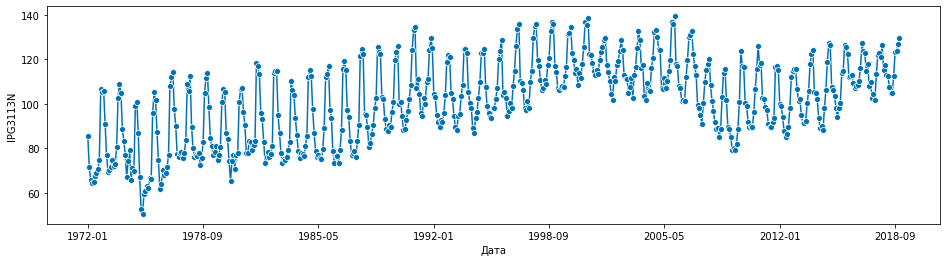

In [21]:
plot_series(y)
plt.xlabel("Дата")
plt.ylabel("IPG3113N")

plt.show()

<Figure size 432x288 with 0 Axes>

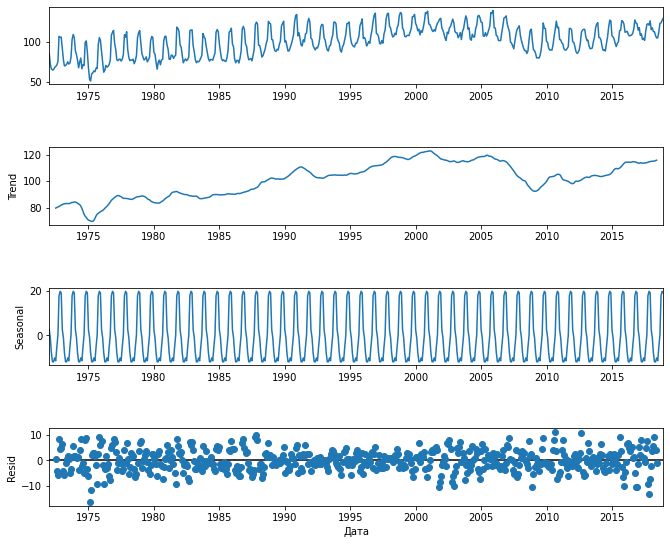

In [22]:
df = y.copy()
df.index = df.index.to_timestamp()
decompose = seasonal_decompose(df)

fig = plt.figure()  
fig = decompose.plot()  
fig.set_size_inches(10, 8)

plt.xlabel("Дата")
plt.show()

Из графического анализа можно сделать вывод, что в данных присутствует месячная аддитивная сезонность, однако определить линейность тренда, а также тип ошибки пока не представляется возможным. Поэтому можно взять модели вида $ETS(?,?,A)$ и сравнить их методом скользящего окна.

### Применение метода для сравнения моделей

Глубина прогноза и размер горизонта прогнозирования обычно выбирается аналитически или же подбором, например, с помощью анализа прогноза в обратном направлении для каждого размера окна.

Так как наш временной ряд состоит из ежемесячных наблюдений в течение 47 лет, возьмем глубину прогноза равную 2 годам и будем предсказывать следующий год, то есть делать многошаговый, а не одношаговый прогноз для более быстрого получения результата.

Напомним, что мы рассматриваем все виды моделей с аддитивной сезонностью.

In [23]:
forecaster = AutoETS(sp=12)
cv = SlidingWindowSplitter(fh=12, window_length=24, initial_window=24, start_with_window=True)
param_grid = {'error': ['add', 'mul'], 'trend' : [None, 'add', 'mul']}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, scoring=sMAPE())
gscv.fit(y)

ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x7f8c80de3950>,
                        forecaster=AutoETS(sp=12),
                        param_grid={'error': ['add', 'mul'],
                                    'trend': [None, 'add', 'mul']},
                        scoring=<sktime.performance_metrics.forecasting._classes.sMAPE object at 0x7f8c8c3305d0>)

Выведем получившиеся результаты:

In [24]:
results = pd.DataFrame(gscv.cv_results_).drop(columns=['mean_fit_time', 'mean_score_time', 'params'])
results = results.sort_values(by='mean_test_sMAPE').reset_index(drop=True)
results

,param_error,param_trend,mean_test_sMAPE,rank_test_sMAPE
0,add,None,0.134022,1
1,mul,None,0.134022,1
2,mul,add,1.029276,3
3,add,add,1.030118,4
4,mul,mul,1.645133,5
5,add,mul,1.653094,6


Заметим, что наилучшими по результатам метрики [SMAPE](https://ru.qaz.wiki/wiki/Symmetric_mean_absolute_percentage_error) оказались модели без тренда, с аддитивной и мультипликативной ошибкой. Действительно, на графике разложения нашего временного ряда тренд был слабо выражен, а природу ошибки было сложно определить, поэтому полученные результаты можно расценивать как верные.






**Справка**: Симметричный средний процент отклонения (SMAPE) - одна из наиболее популярных метрик оценки качества алгоритмов прогнозирования временных рядов. 

Она вычисляется как модуль разницы между ответом алгоритма и истинным значением, которое делится на их среднее:

$\text{SMAPE}=100\% \cdot \dfrac {1}{n}\sum_{i=1}^{n}\dfrac {\left|y_{i}-\hat y_{i}\right|}{\frac{|\hat y_{i}|+|y_{i}|}{2}}$

## Итог

В данном туториале мы:

- Познакомились с группой моделей $ETS.$ 
- Научились аналитически и автоматически подбирать наиболее подходящую модель.
- Рассмотрели метод скользящего окна.
- Применили все полученные знания на практике, прогнозируя данные по производству молока и сладостей.

Еще раз хочется подметить, что очень важно рассматривать графики самого временного ряда и его компонент перед выбором модели для понимания природы данных. Это заметно помогает ускорить процесс подбора, так как на больших временных рядах (у нас были небольшие массивы данных) время автоматического подбора может быть слишком большим.

## Полезные ссылки

1.   Еще раз укажем подробный [супер-учебник](https://otexts.com/fpp3/) "Forecasting: principles and practice" Роба Хиндмана и Джорджа Атанасопулоса по временным рядам и моделям прогнозирования (на англ.).

2. Краткое [объяснение](https://wiki.loginom.ru/articles/windowing-method.html) метода скользящего окна.

3. Интересная [статья](https://habr.com/ru/post/347378/) на habr.com про метод скользящего окна (с интригующим названием "Что общего у собеседования кодера и игры «Змейка»?").

4. Обзорная [статья](https://towardsdatascience.com/an-overview-of-time-series-forecasting-models-a2fa7a358fcb) (на англ.) про различные модели прогнозирования, если интересно узнать какие модели еще существуют помимо наиболее популярных.

5. Полезная [статья](https://alexanderdyakonov.files.wordpress.com/2018/10/book_08_metrics_12_blog1.pdf) на русском про различные метрики качества.


Что ж, на этом наше путешествие закончено. Надеемся наш туториал оказался полезен и желаем успехов в изучении временных рядов и их прогнозировании :)

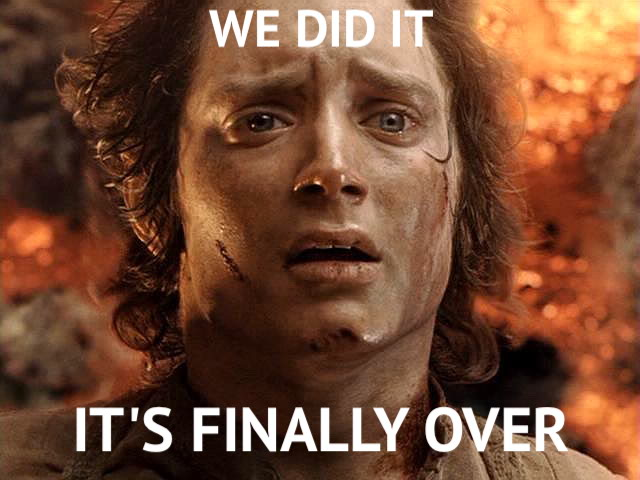